# Load the data and fit a simple model
This simple example shows you how to load the data into a jupyter notebook and fit a simple model.

In [1]:
# Load in some libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load in the data

In [2]:
# Relative path to data
trainPath = '../../data/train.csv'
testPath = '../../data/test.csv'

train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)

### Look at the data

In [3]:
print "Shape of training data: " + str(train.shape)
print "Shape of test data: " + str(test.shape)

Shape of training data: (1460, 81)
Shape of test data: (1459, 80)


In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


Now look at the distribution of sale prices:

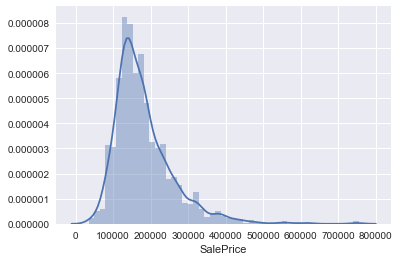

In [5]:
sns.distplot(train['SalePrice']);

# Preprocessing

## Separating training and target data

In [6]:
# Pull out the Ids for the kaggle submission and drop from the test set (will only need test Ids.
testIds = test.pop('Id')
trainIds = train.pop('Id')

# Take the log of 1 plus sale price for training and submission
train.SalePrice = np.log1p(train.SalePrice)
y=train.SalePrice

print train.shape, test.shape, y.shape

(1460, 80) (1459, 79) (1460,)


### Handle missing values for features where median/mean or most common value doesn't make sense

In [7]:
# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

### Some numerical features are actually really categories

In [8]:
train = train.replace({"MSSubClass" : {20 : "SC20", 
                                       30 : "SC30", 
                                       40 : "SC40", 
                                       45 : "SC45", 
                                       50 : "SC50", 
                                       60 : "SC60", 
                                       70 : "SC70", 
                                       75 : "SC75", 
                                       80 : "SC80", 
                                       85 : "SC85", 
                                       90 : "SC90", 
                                       120 : "SC120", 
                                       150 : "SC150", 
                                       160 : "SC160", 
                                       180 : "SC180", 
                                       190 : "SC190"},
                       "MoSold" : {1 : "Jan", 
                                   2 : "Feb", 
                                   3 : "Mar", 
                                   4 : "Apr", 
                                   5 : "May", 
                                   6 : "Jun",
                                   7 : "Jul", 
                                   8 : "Aug", 
                                   9 : "Sep", 
                                   10 : "Oct", 
                                   11 : "Nov", 
                                   12 : "Dec"}
                      })

### Encode some categorical features as ordered numbers when there is information in the order

In [9]:
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

## Feature Engineering

### Find most important features relative to target

In [10]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000
OverallQual      0.817
GrLivArea        0.701
GarageCars       0.681
ExterQual        0.679
KitchenQual      0.668
GarageArea       0.651
BsmtQual         0.616
TotalBsmtSF      0.612
1stFlrSF         0.597
FullBath         0.595
YearBuilt        0.587
YearRemodAdd     0.566
FireplaceQu      0.546
GarageYrBlt      0.541
TotRmsAbvGrd     0.534
Fireplaces       0.489
HeatingQC        0.474
MasVnrArea       0.427
BsmtFinSF1       0.372
GarageQual       0.363
GarageCond       0.357
BsmtExposure     0.337
BsmtFinType1     0.335
WoodDeckSF       0.334
OpenPorchSF      0.321
2ndFlrSF         0.319
HalfBath         0.314
PavedDrive       0.305
BsmtCond         0.275
LotArea          0.257
BsmtFullBath     0.236
BsmtUnfSF        0.222
BedroomAbvGr     0.209
LotFrontage      0.179
Functional       0.136
ScreenPorch      0.121
PoolQC           0.078
PoolArea         0.070
Street           0.057
3SsnPorch        0.055
ExterCond

In [11]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 53
Categorical features : 26


In [12]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [13]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandrua Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

43 skewed numerical features to log transform


In [14]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


### Fit a model!

In [15]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 256
X_train : (1022, 256)
X_test : (438, 256)
y_train : (1022,)
y_test : (438,)


In [16]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We can go ahead and fit a model:

### Function for evaluating the fit of different models

In [23]:
def tryModel(model, X_train, y_train, X_test, y_test):
    """
    model: a fitted sklearn model
    X_train: the training data used to train `model`
    y_train: the target data used to train `model`
    X_test: the test data for evaluating `model`
    y_test: the test target data for evaluating the `model`
    """
    
    # Predict on new data and plot the results
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Plot the results
    sns.regplot(x=y_test, y=y_test_pred-y_test);
    
    # Evaluate the rms error on the train set:
    rmse_log_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
    rmse_abs_train = np.sqrt(mean_squared_error(np.exp(y_train_pred), np.exp(y_train)))

    print  "Training Set Errors:" \
           "\nTypical log error in housing sale price prediction: " + str(rmse_log_train) + \
           "\nTypical absolute error in housing sale price prediction: $" + str(rmse_abs_train)

    # Evaluate the rms error on the validation set:
    rmse_log = np.sqrt(mean_squared_error(y_test_pred, y_test))
    rmse_abs = np.sqrt(mean_squared_error(np.exp(y_test_pred), np.exp(y_test)))

    print  "\nValidation Set Errors:" \
           "\nTypical log error in housing sale price prediction: " + str(rmse_log) + \
           "\nTypical absolute error in housing sale price prediction: $" + str(rmse_abs)

## Try some models!

### Random Forest
First let's try sklearn's Random Forest Regressor: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [31]:
modelRF = RandomForestRegressor(
    verbose=True,
    max_depth=None,
    max_features='sqrt',
    n_estimators=1000,
    oob_score=False,
    n_jobs=6
)
modelRF.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=6, oob_score=False, random_state=None,
           verbose=True, warm_start=False)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    0.8s finished


Training Set Errors:
Typical log error in housing sale price prediction: 0.0789493744031
Typical absolute error in housing sale price prediction: $16134.7642723

Validation Set Errors:
Typical log error in housing sale price prediction: 0.134880739201
Typical absolute error in housing sale price prediction: $34308.9466864


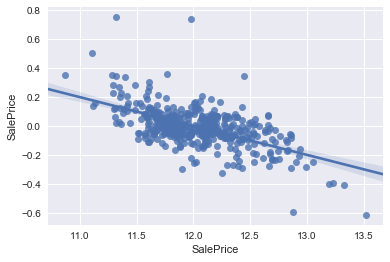

In [32]:
tryModel(modelRF, X_train, y_train, X_test, y_test)